**Imports**

In [1]:
import torch
print(torch.__version__)
import torch.nn as nn
import pandas as pd
from collections import Counter
import numpy as np
import torchvision
import torch.nn.functional as F

## This module provides tools to transform images, such as resizing, cropping, flipping, converting to tensors, and normalizing
import torchvision.transforms as transforms

#This is a dataset class that loads images from a directory structure where each folder is treated as a separate class.
#It automatically assigns labels based on subfolder names.
import torchvision.datasets as datasets


#This utility creates an iterable over the dataset, allowing for loading data in batches, shuffling, and parallel data loading with multiple workers.
from torch.utils.data import DataLoader

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import torchvision.models as models
import copy
import random

# Import sklearn metrics for evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Import visualization tools
import matplotlib.pyplot as plt
import seaborn as sns



2.5.0+cu121


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00


In [3]:
!pip install scikit-optimize skorch torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 21.0 MB/s eta 0:00:00


In [4]:
from torch.utils.data import DataLoader, random_split
# Set a fixed random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Additional settings for GPU reproducibility
#torch.cuda.manual_seed(seed)
#torch.cuda.manual_seed_all(seed)            # If using multiple GPUs
#torch.backends.cudnn.deterministic = True   # Ensures deterministic behavior for some GPU operations
#torch.backends.cudnn.benchmark = False      # Disables auto-tuning for determinism

**Data Preprocessing and Load CIFAR-10 Dataset**

In [5]:
# Define Cutout transformation
class Cutout:
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.0

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img

# Define transformations for training, validation, and testing data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),          # Random cropping with padding
    transforms.RandomHorizontalFlip(),             # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Color Jitter
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # Normalize with CIFAR-10 stats
    Cutout(n_holes=1, length=8)                    # Cutout
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset
trainset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split the training set into training and validation sets
train_size = int(0.8 * len(trainset_full))
val_size = len(trainset_full) - train_size
trainset, valset = random_split(trainset_full, [train_size, val_size])



# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)


print(f"Number of training samples: {len(trainset)}")
print(f"Number of validation samples: {len(valset)}")
print(f"Number of test samples: {len(testset)}")

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


**ResNet50**

In [6]:
import torch
import torch.nn as nn
from torchvision import models

# Define a custom ResNet50 model with Dropout for CIFAR-10
class ResNet50WithDropout(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(ResNet50WithDropout, self).__init__()

        # Initialize ResNet-50 without pre-trained weights
        self.model = models.resnet50(pretrained=False)

        # Modify the first convolutional layer to adapt to CIFAR-10 images (32x32)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove the max pooling layer to retain more spatial information for smaller images
        self.model.maxpool = nn.Identity()

        # Modify the final fully connected layer to output 10 classes (for CIFAR-10)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 10)

        # Add a Dropout layer before the final fully connected layer with the specified probability
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        # Pass the input through the model
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)

        # Flatten the output and apply dropout before the final layer
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Dropout
        x = self.model.fc(x)  # Final fully connected layer
        return x

# Instantiate the model with a dropout probability of 0.5
model = ResNet50WithDropout(dropout_prob=0.5)

# Print the model to verify the structure
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet50WithDropout(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

**Loss Function, Optimizer, and Scheduler**

In [7]:


# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Cross-Entropy Loss with optional label smoothing
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: SGD with momentum and weight decay
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Scheduler: StepLR to decrease learning rate every 30 epochs by a factor of 0.1
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

**Hyperparameters to Experiment With**

In [8]:
import itertools

# Define a set of hyperparameters to tune
hyperparams = {
    'learning_rate': [0.01, 0.001],
    'batch_size': [64, 128],
    'dropout_prob': [0.3, 0.5],
    'weight_decay': [1e-4, 5e-4],
    'optimizer': ['SGD', 'Adam']
}

# Generate all possible combinations of hyperparameters
param_combinations = list(itertools.product(
    hyperparams['learning_rate'],
    hyperparams['batch_size'],
    hyperparams['dropout_prob'],
    hyperparams['weight_decay'],
    hyperparams['optimizer']
))


**Set Up the Training and Evaluation Loops**

In [9]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import copy

# Define a function to train and evaluate the model with given hyperparameters
def train_and_evaluate(params, trainset, valset, num_epochs=10):
    learning_rate, batch_size, dropout_prob, weight_decay, optimizer_name = params

    # Create model with specified dropout probability
    model = ResNet50WithDropout(dropout_prob=dropout_prob)
    model = model.to(device)

    # Set up data loaders
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Define loss function
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Choose optimizer
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

    # Training and validation loop
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()

    return best_val_acc, best_model_wts


**Run Hyperparameter Tuning and Save the Best Model**

In [10]:
best_accuracy = 0.0
best_params = None
best_model_state = None

# Iterate over all combinations of hyperparameters
for params in param_combinations:
    print(f"\nTesting combination: {params}")

    # Train and evaluate with current parameters
    val_acc, model_wts = train_and_evaluate(params, trainset, valset, num_epochs=10)

    # Check if the current combination gives better accuracy
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_params = params
        best_model_state = model_wts

# Print the best parameters and accuracy
print(f"\nBest validation accuracy: {best_accuracy:.2f}%")
print(f"Best hyperparameters: Learning rate={best_params[0]}, Batch size={best_params[1]}, "
      f"Dropout={best_params[2]}, Weight decay={best_params[3]}, Optimizer={best_params[4]}")



Testing combination: (0.01, 64, 0.3, 0.0001, 'SGD')

Testing combination: (0.01, 64, 0.3, 0.0001, 'Adam')

Testing combination: (0.01, 64, 0.3, 0.0005, 'SGD')

Testing combination: (0.01, 64, 0.3, 0.0005, 'Adam')

Testing combination: (0.01, 64, 0.5, 0.0001, 'SGD')

Testing combination: (0.01, 64, 0.5, 0.0001, 'Adam')

Testing combination: (0.01, 64, 0.5, 0.0005, 'SGD')

Testing combination: (0.01, 64, 0.5, 0.0005, 'Adam')

Testing combination: (0.01, 128, 0.3, 0.0001, 'SGD')

Testing combination: (0.01, 128, 0.3, 0.0001, 'Adam')

Testing combination: (0.01, 128, 0.3, 0.0005, 'SGD')

Testing combination: (0.01, 128, 0.3, 0.0005, 'Adam')

Testing combination: (0.01, 128, 0.5, 0.0001, 'SGD')

Testing combination: (0.01, 128, 0.5, 0.0001, 'Adam')

Testing combination: (0.01, 128, 0.5, 0.0005, 'SGD')

Testing combination: (0.01, 128, 0.5, 0.0005, 'Adam')

Testing combination: (0.001, 64, 0.3, 0.0001, 'SGD')

Testing combination: (0.001, 64, 0.3, 0.0001, 'Adam')

Testing combination: (0.00

**Final Training with the Best Hyperparameters**

In [11]:
# Load the best model weights
model = ResNet50WithDropout(dropout_prob=best_params[2])
model.load_state_dict(best_model_state)
model = model.to(device)

# Reinitialize data loaders with the best batch size
train_loader = DataLoader(trainset, batch_size=best_params[1], shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=best_params[1], shuffle=False, num_workers=4)
test_loader = DataLoader(testset, batch_size=best_params[1], shuffle=False, num_workers=4)

# Define optimizer and scheduler with the best parameters
if best_params[4] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=best_params[0], momentum=0.9, weight_decay=best_params[3])
elif best_params[4] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params[0], weight_decay=best_params[3])

scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Train for a larger number of epochs with the best hyperparameters
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    scheduler.step()

    # Evaluate on the test set at the end of each epoch if desired
    # Add code for evaluating on the test set if you wish to track test accuracy throughout

print("Final training with best hyperparameters complete.")


Final training with best hyperparameters complete.


In [12]:
# Define baseline hyperparameters
baseline_params = {
    'learning_rate': 0.01,
    'batch_size': 128,
    'dropout_prob': 0.5,
    'weight_decay': 5e-4,
    'optimizer': 'SGD'
}

# Initialize model with baseline dropout probability
model = ResNet50WithDropout(dropout_prob=baseline_params['dropout_prob'])
model = model.to(device)

# Data loaders with baseline batch size
train_loader = DataLoader(trainset, batch_size=baseline_params['batch_size'], shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=baseline_params['batch_size'], shuffle=False, num_workers=4)
test_loader = DataLoader(testset, batch_size=baseline_params['batch_size'], shuffle=False, num_workers=4)

# Define loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Choose optimizer
optimizer = optim.SGD(model.parameters(), lr=baseline_params['learning_rate'], momentum=0.9, weight_decay=baseline_params['weight_decay'])

# Define learning rate scheduler
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Training with baseline hyperparameters
num_epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

# Store results for comparison
baseline_results = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}


Epoch [1/100] Train Loss: 2.5587, Train Acc: 20.20%, Val Loss: 2.1057, Val Acc: 28.11%
Epoch [2/100] Train Loss: 2.0723, Train Acc: 31.27%, Val Loss: 1.9669, Val Acc: 37.39%
Epoch [3/100] Train Loss: 1.8645, Train Acc: 39.02%, Val Loss: 2.2751, Val Acc: 44.44%
Epoch [4/100] Train Loss: 1.7142, Train Acc: 45.43%, Val Loss: 1.7083, Val Acc: 49.85%
Epoch [5/100] Train Loss: 1.5903, Train Acc: 50.74%, Val Loss: 1.7074, Val Acc: 53.38%
Epoch [6/100] Train Loss: 1.5005, Train Acc: 55.03%, Val Loss: 1.4548, Val Acc: 58.91%
Epoch [7/100] Train Loss: 1.4032, Train Acc: 59.71%, Val Loss: 1.3801, Val Acc: 61.02%
Epoch [8/100] Train Loss: 1.3159, Train Acc: 64.02%, Val Loss: 1.2943, Val Acc: 64.58%
Epoch [9/100] Train Loss: 1.2297, Train Acc: 67.75%, Val Loss: 1.2579, Val Acc: 67.74%
Epoch [10/100] Train Loss: 1.1733, Train Acc: 70.45%, Val Loss: 1.2372, Val Acc: 70.55%
Epoch [11/100] Train Loss: 1.1203, Train Acc: 72.83%, Val Loss: 1.1482, Val Acc: 71.91%
Epoch [12/100] Train Loss: 1.0737, Train 

**Train the Model with Default Hyperparameters (Before Optimization)**

In [13]:
# Define baseline hyperparameters
baseline_params = {
    'learning_rate': 0.01,
    'batch_size': 128,
    'dropout_prob': 0.5,
    'weight_decay': 5e-4,
    'optimizer': 'SGD'
}

# Initialize model with baseline dropout probability
model = ResNet50WithDropout(dropout_prob=baseline_params['dropout_prob'])
model = model.to(device)

# Data loaders with baseline batch size
train_loader = DataLoader(trainset, batch_size=baseline_params['batch_size'], shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=baseline_params['batch_size'], shuffle=False, num_workers=4)
test_loader = DataLoader(testset, batch_size=baseline_params['batch_size'], shuffle=False, num_workers=4)

# Define loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Choose optimizer
optimizer = optim.SGD(model.parameters(), lr=baseline_params['learning_rate'], momentum=0.9, weight_decay=baseline_params['weight_decay'])

# Define learning rate scheduler
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Training with baseline hyperparameters
num_epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

# Store results for comparison
baseline_results = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}


Epoch [1/100] Train Loss: 2.5782, Train Acc: 19.23%, Val Loss: 6.6968, Val Acc: 28.19%
Epoch [2/100] Train Loss: 2.0069, Train Acc: 32.24%, Val Loss: 1.9817, Val Acc: 39.49%
Epoch [3/100] Train Loss: 1.8199, Train Acc: 40.45%, Val Loss: 1.7737, Val Acc: 44.90%
Epoch [4/100] Train Loss: 1.6709, Train Acc: 47.06%, Val Loss: 1.5857, Val Acc: 50.92%
Epoch [5/100] Train Loss: 1.5496, Train Acc: 52.57%, Val Loss: 1.6149, Val Acc: 57.01%
Epoch [6/100] Train Loss: 1.4390, Train Acc: 57.79%, Val Loss: 1.4151, Val Acc: 60.20%
Epoch [7/100] Train Loss: 1.3499, Train Acc: 61.97%, Val Loss: 1.3300, Val Acc: 63.14%
Epoch [8/100] Train Loss: 1.2699, Train Acc: 65.79%, Val Loss: 1.2400, Val Acc: 66.81%
Epoch [9/100] Train Loss: 1.2034, Train Acc: 69.16%, Val Loss: 1.1951, Val Acc: 69.27%
Epoch [10/100] Train Loss: 1.1480, Train Acc: 71.56%, Val Loss: 1.1646, Val Acc: 71.15%
Epoch [11/100] Train Loss: 1.0940, Train Acc: 74.03%, Val Loss: 1.1164, Val Acc: 72.48%
Epoch [12/100] Train Loss: 1.0519, Train 

**Train the Model with Best Hyperparameters (After Optimization)**

In [14]:
# Best hyperparameters from hyperparameter tuning
best_params = {
    'learning_rate': best_params[0],    # Replace with best learning rate
    'batch_size': best_params[1],       # Replace with best batch size
    'dropout_prob': best_params[2],     # Replace with best dropout
    'weight_decay': best_params[3],     # Replace with best weight decay
    'optimizer': best_params[4]         # Replace with best optimizer
}

# Initialize model with best dropout probability
model = ResNet50WithDropout(dropout_prob=best_params['dropout_prob'])
model = model.to(device)

# Data loaders with best batch size
train_loader = DataLoader(trainset, batch_size=best_params['batch_size'], shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=best_params['batch_size'], shuffle=False, num_workers=4)
test_loader = DataLoader(testset, batch_size=best_params['batch_size'], shuffle=False, num_workers=4)

# Define optimizer
if best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=best_params['learning_rate'], momentum=0.9, weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])

# Define learning rate scheduler
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Training with best hyperparameters
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

# Store results for comparison
optimized_results = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}


Epoch [1/100] Train Loss: 1.8944, Train Acc: 36.17%, Val Loss: 1.6351, Val Acc: 47.38%
Epoch [2/100] Train Loss: 1.5070, Train Acc: 54.12%, Val Loss: 1.5014, Val Acc: 56.23%
Epoch [3/100] Train Loss: 1.3523, Train Acc: 62.12%, Val Loss: 1.3845, Val Acc: 61.48%
Epoch [4/100] Train Loss: 1.2570, Train Acc: 66.80%, Val Loss: 1.3342, Val Acc: 63.05%
Epoch [5/100] Train Loss: 1.1918, Train Acc: 69.68%, Val Loss: 1.3064, Val Acc: 65.06%
Epoch [6/100] Train Loss: 1.1391, Train Acc: 72.34%, Val Loss: 1.1267, Val Acc: 72.77%
Epoch [7/100] Train Loss: 1.0976, Train Acc: 74.21%, Val Loss: 1.2044, Val Acc: 69.33%
Epoch [8/100] Train Loss: 1.0686, Train Acc: 75.54%, Val Loss: 1.0815, Val Acc: 74.82%
Epoch [9/100] Train Loss: 1.0419, Train Acc: 76.66%, Val Loss: 1.0241, Val Acc: 77.51%
Epoch [10/100] Train Loss: 1.0143, Train Acc: 77.93%, Val Loss: 1.0953, Val Acc: 74.74%
Epoch [11/100] Train Loss: 0.9940, Train Acc: 78.99%, Val Loss: 1.0035, Val Acc: 78.22%
Epoch [12/100] Train Loss: 0.9767, Train 

**Compare Results Before and After Hyperparameter Optimization**

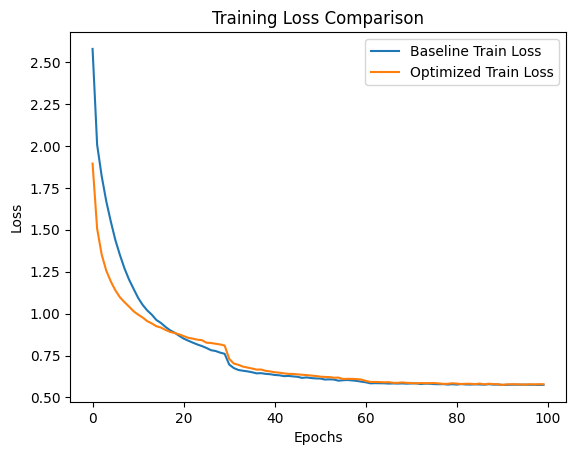

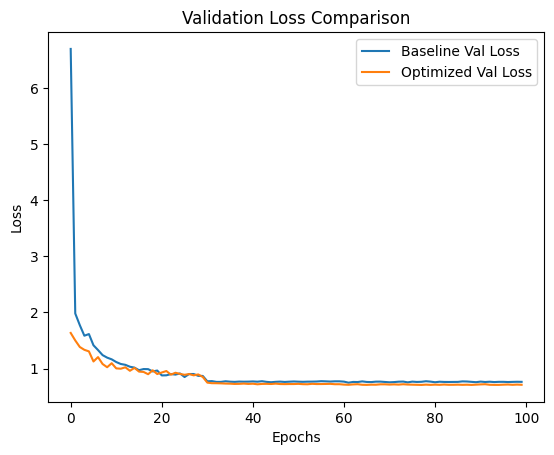

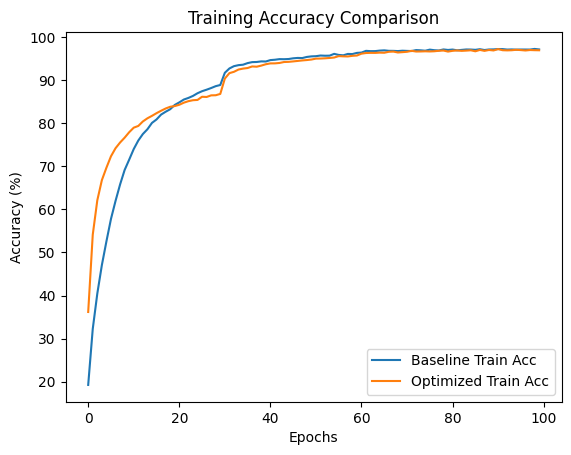

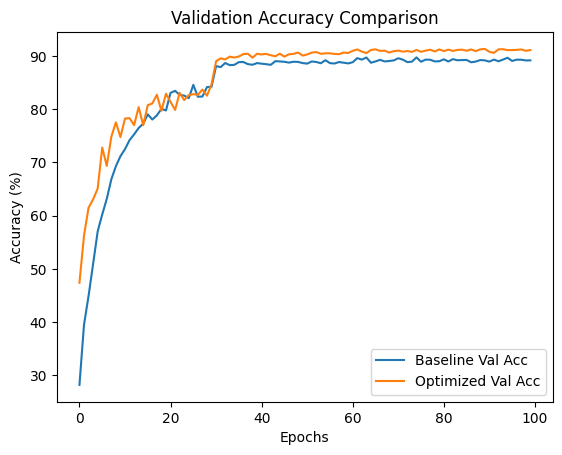

In [15]:
import matplotlib.pyplot as plt

# Plot Training Losses
plt.figure()
plt.plot(baseline_results['train_losses'], label='Baseline Train Loss')
plt.plot(optimized_results['train_losses'], label='Optimized Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()

# Plot Validation Losses
plt.figure()
plt.plot(baseline_results['val_losses'], label='Baseline Val Loss')
plt.plot(optimized_results['val_losses'], label='Optimized Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.show()

# Plot Training Accuracies
plt.figure()
plt.plot(baseline_results['train_accuracies'], label='Baseline Train Acc')
plt.plot(optimized_results['train_accuracies'], label='Optimized Train Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.show()

# Plot Validation Accuracies
plt.figure()
plt.plot(baseline_results['val_accuracies'], label='Baseline Val Acc')
plt.plot(optimized_results['val_accuracies'], label='Optimized Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.show()


 **Test the Model and Get Predictions**

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Put the model in evaluation mode
model.eval()

# Variables to store predictions and true labels
all_preds = []
all_labels = []

# Evaluate the model on the test set
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Get predictions
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        # Store predictions and labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays for easier evaluation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


**Calculate and Print Performance Metrics**

In [17]:
# Calculate overall accuracy
accuracy = np.mean(all_preds == all_labels) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Classification report: precision, recall, and F1-score for each class
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))


Test Accuracy: 92.86%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.93      0.95      0.94      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.91      0.91      0.91      1000
         cat       0.87      0.82      0.84      1000
        deer       0.91      0.94      0.92      1000
         dog       0.86      0.89      0.88      1000
        frog       0.95      0.95      0.95      1000
       horse       0.96      0.95      0.95      1000
        ship       0.97      0.96      0.97      1000
       truck       0.96      0.96      0.96      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



**Confusion Matrix**

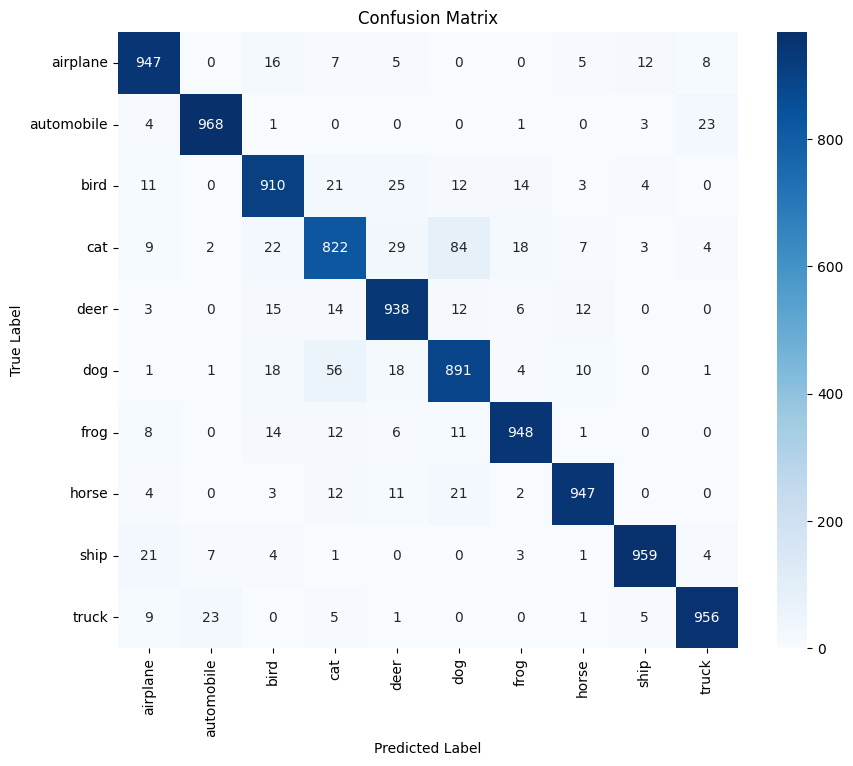

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


**end -------**